# Re-analysis from Pelka et al. (2019)

In [1]:
from plotnine import *
import numpy as np
import pandas as pd

## Expression in Ki67+ cancer cells
From the Loupe file provided for epithelial, we first selected cancer cells based on more than 2 counts for both LY6E and TGFBI. Among these cells, the ones with more than 2 counts for MKI67 were labelled as proliferation "High" while the others were classified as "Low".

In [2]:
labels = pd.read_csv("../../data/pelka-reanalysis/Labels-Ki67.csv", index_col=0)
labels.head()

,Prolif
Barcode,
AAACCTGGTTGTCGCG-1,Epi
AAACCTGTCCTTGGTC-1,Epi
AAACGGGCAGAGTGTG-1,Malignant
AAAGATGCAAGGTTTC-1,Malignant
AAAGATGGTGCCTGCA-1,Epi


In [3]:
expr = pd.read_csv("../../data/pelka-reanalysis/Expression-Ki67.csv", index_col=0, sep =";")
print(expr.shape)
expr.head()

(168672, 6)


,GLUL,SLC16A1,SLC7A5,SLC3A2,CYCS,CPT1A
Barcode,,,,,,
AAACCTGCATGCTAGT-1,0,0,3,0,5,0
AAACCTGGTAGCCTAT-1,0,1,0,0,1,0
AAACCTGGTTGTCGCG-1,4,1,3,3,13,0
AAACCTGTCATGTGGT-1,0,0,0,1,6,0
AAACCTGTCCTTGGTC-1,7,2,2,0,31,2


In [4]:
expr = expr.join(labels, how="inner")

In [5]:
# Display violin plots of metabolic marker intensity per cell
# Split by aggressiveness (low = right violin, high = left violin)

# Rename values for clarity
expr["Proliferation"] = expr.Prolif.replace({"Epi": "Low", "Malignant": "High"})

# Reorder by pathway
path_order = ["CYCS", "CPT1A", "SLC16A1", "SLC7A5", "SLC3A2", "GLUL"]

# Convert to long format
df_long = pd.melt(expr.loc[:,path_order+["Proliferation"]], id_vars=["Proliferation"], value_vars=path_order)

df_long["variable"] = pd.Categorical(df_long["variable"], 
    categories=path_order,
    ordered=True)

df_long["variable"] = df_long["variable"].replace({
    "CYCS": "CYCS\n(CytC)",
    "SLC16A1": "SLC16A1\n(MCT1)",
    "SLC7A5": "SLC7A5\n(CD98)",
    "SLC3A2": "SLC3A2\n(CD98)",
    "GLUL": "GLUL\n(GS)",
})

/tmp/ipykernel_45013/4289163624.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4.5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig6/expression_ki67_cancer_pelka.pdf


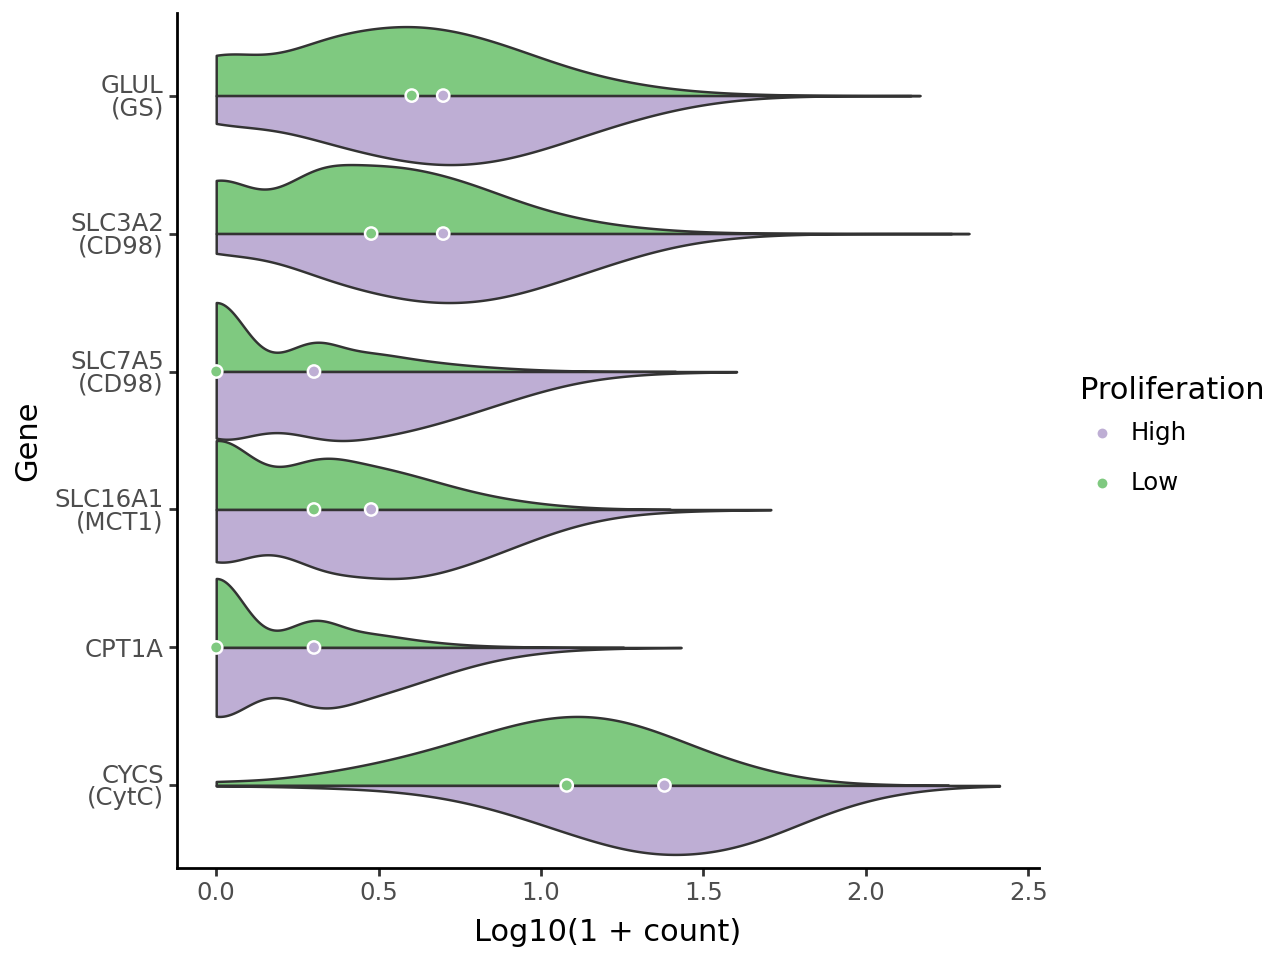

In [6]:
df_long["logvalue"] = np.log10(1 + df_long["value"])

gp = ggplot(df_long, aes(x="variable", y="logvalue")) +\
    geom_violin(data = df_long.loc[df_long.Proliferation == "Low",:], 
                fill = "#7fc980", 
                style="right", 
                scale="width", 
                width = 1,
                adjust = 3) +\
    geom_violin(data = df_long.loc[df_long.Proliferation == "High",:], 
                fill = "#beaed4", 
                style="left", 
                scale="width", 
                width = 1,
                adjust = 3) +\
    stat_summary(data = df_long, 
                 mapping = aes(fill = "Proliferation"),
                 fun_y=np.median, geom='point', color='white', 
                 size=2) +\
    scale_fill_manual(values = ["#beaed4", "#7fc980"]) +\
    theme_classic() +\
    coord_flip() +\
    ylab("Log10(1 + count)") +\
    xlab("Gene") +\
    guides(fill=guide_legend(title="Proliferation"))

ggsave(gp, "../../figures/fig6/expression_ki67_cancer_pelka.pdf", width = 6, height = 4.5)
gp